# Simulations for colored noise
GitHub project: **https://github.com/Fertmeneses/qubit-noise-spectroscopy**

Author: **Fernando Meneses**.

In [1]:
# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
from random import random
from scipy.signal.windows import hann
from scipy.signal import welch

# General functions:
def build_color_noise_PSD(
    f_color,Df,dt=1e-8,N=1e6,Q=5e-4
    ):
    """
    Generates the magnetic signal and time vectors for a colored noise
    plus random experimental noise. Furthermore, generates the Power
    Spectral Density (PSD) and frequency vectors associated to that noise.

    --- Inputs ---

    {f_color} [Float]: Central frequency for the colored noise. Units [Hz].
    {Df} [Float]: Frequency bandwidth (half-width at half-maximum) for the
    colored noise. Units [Hz].
    {dt} [Float]: Time resolution for the magnetic signal. Units [s].
    {N} [Integer]: Number of points for time and frequency vectors.
    {Q} [Float or Integer]: Scaling constant used in randomization

    --- Returns ---

    {t_vec} [Numpy array]: Time vector. Units [s].
    {mag_signal} [Numpy array]: Magnetic signal vector, including the colored
    noise (correlated) and experimental random noise (uncorrelated). Arb. units.
    {freq_vec} [Numpy array]: Frequency vector. Units [Hz].
    {PSD_vec} [Numpy array]: Power Spectral Density vector. Arb. units.
    
    """
    
    # Noise generation:
    N = int(N) # Convert to integer, just in case
    a = 2*0.15/Df # Correlation time [s]
    var = Q/(2*a)*(1-np.exp(-2*dt/a)) # Half-width for gaussian distributions [Hz]
    C = np.exp(-dt/a) # Correlation factor
    t_vec = np.arange(N)*dt # Time vector [s]
    mag_signal = np.zeros(N) # Initiate vector
    mag_signal[0] = var*random() # Set initial value
    unc_noise = np.random.normal(0, var, N) # Uncorrelated noise
    # Define values for noise vector recursively:
    for i in range(N-1):
        mag_signal[i+1] = mag_signal[i]*C + unc_noise[i]
    # Shift the power spectrum to the color frequency:
    mag_signal = np.multiply( # Element-wise multiplication
        np.cos(2*np.pi*f_color*t_vec),mag_signal)
    mag_signal /= np.max(np.abs(mag_signal)) # Normalize noise to [-1,1] range

    # Calculate power spectral density (PSD), using Welch's method:
    N_wdw = int(N*0.1) # Number of points for a single window
    freq_vec, PSD_vec = welch(mag_signal,fs=fs,nperseg=N_wdw) # Frequency [Hz] and PSD [arb. units]

    return t_vec, mag_signal, freq_vec, PSD_vec

def plot_noise_PSD(
    t_vec,mag_signal,freq_vec,PSD_vec,t_lims=None,mag_lims=None,
    f_lims=None,PSD_lims=None,f0=None,Df=None,color='teal',
    figsize=(8,4),save_name=None,save_format='png'
    ):
    """
    Plots the magnetic signal as a function of time, associated to the color
    noise, and the corresponding Power Spectral Density (PSD) as a function
    of frequency.

    --- Inputs ---

    {t_vec} [Numpy array]: Time vector. Units [s].
    {mag_signal} [Numpy array]: Magnetic signal vector, including the colored
    noise (correlated) and experimental random noise (uncorrelated). Arb. units.
    {freq_vec} [Numpy array]: Frequency vector. Units [Hz].
    {PSD_vec} [Numpy array]: Power Spectral Density vector. Arb. units.
    {t_lims} [None or list]: If a list is provided, it must be have two elements
    [t_min,t_max] for the minimum and maximum time values to show in the plot.
    {mag_lims} [None or list]: If a list is provided, it must be have two elements
    [mag_min,mag_max] for the minimum and maximum magnetic values to show in the plot.
    {f_lims} [None or list]: If a list is provided, it must be have two elements
    [f_min,f_max] for the minimum and maximum frequency values to show in the plot.
    {PSD_lims} [None or list]: If a list is provided, it must be have two elements
    [PSD_min,PSD_max] for the minimum and maximum PSD values to show in the plot.
    {f0} [Float]: Central frequency for the colored noise, it will be displayed with
    a black dashed line in the plot. Units [Hz].
    {Df} [Float]: Frequency bandwidth (half-width at half-maximum) for the
    colored noise, it will be plot as two gray dashed lines in the plot. Units [Hz].
    {color} [String or Matplotlib color]: Color for the signal and PSD curves.
    {figsize} [Tuple]: 2 integer-elements indicating the width and height dimensions 
    for the figure.
    {save_name} [String]: filename for the figure (don't include the extension). 
    If None, no figure is saved.
    {save_format} [String]: saving format for the figure,don't include the dot.

    --- Returns ---

    A figure with two subplots:
    Left: Magnetic signal [arb. units] as a function of time [s].
    Right: PSD [arb. units] as a function of frequency [Hz], in log-log scale.
    
    """
    # Prepare figure:
    fig, (ax_noise,ax_PSD) = plt.subplots(1,2,figsize=figsize)
    # Plot Noise Signal vs. Time:
    ax_noise.plot(t_vec,mag_signal,'-',color=color)
    if t_lims is not None:
        ax_noise.set_xlim(t_lims)
    if mag_lims is not None:
        ax_noise.set_ylim(mag_lims)
    # Plot Power Spectral Density vs. Frequency:
    ax_PSD.plot(freq_vec,PSD_vec,'-o',markersize=3,color=color)
    if f0 is not None:
        ax_PSD.axvline(f0,ls='--',lw=0.5,color='k')
        if Df is not None:
            ax_PSD.axvline(f0-Df/2,ls='--',lw=0.5,color='gray')
            ax_PSD.axvline(f0+Df/2,ls='--',lw=0.5,color='gray')
    ax_PSD.set_xscale('log'), ax_PSD.set_yscale('log')
    if f_lims is not None:
        ax_PSD.set_xlim(f_lims)
    if PSD_lims is not None:
        ax_PSD.set_ylim(PSD_lims)
    fig.tight_layout()
    if save_name:
        if save_format == 'svg':
            plt.savefig(f'{save_name}.svg',format="svg",transparent=True) 
        else:
            plt.savefig(f'{save_name}.{save_format}') 

## Generate a spectral density distribution for a colored noise:

In [2]:
# General parameters related to time-domain:
dt = 1e-8 # Time resolution [s]
fs = 1/dt # Sampling rate [Hz]
N_t = 1e6 # Number of points for the time vector

# Parameters related to different colored-noise:
f0_1, f0_2, f0_3 = 12e3, 25e3, 50e3 # Color frequency [Hz] 
Df_1, Df_2, Df_3 = 2e3, 12e3, 60e3 # Color bandwidth [Hz]

# Generate colored-noise and Power Spectral Density (PSD):
t_vec_1, n_vec_1, f_vec_1, PSD_vec_1 = build_color_noise_PSD(
    f0_1,Df_1,dt=dt,N=N_t)
t_vec_2, n_vec_2, f_vec_2, PSD_vec_2 = build_color_noise_PSD(
    f0_2,Df_2,dt=dt,N=N_t)
t_vec_3, n_vec_3, f_vec_3, PSD_vec_3 = build_color_noise_PSD(
    f0_3,Df_3,dt=dt,N=N_t)

# Plot noise signal vs. time and PSD vs frequency:
figsize = (12,4)
color = ['teal','orange','green']
t_lims = [0,0.002] # [s]
mag_lims = None
f_lims = [1e3,2e6] # [Hz]
PSD_lims = [5e-12,4e-5] 
save_name = None

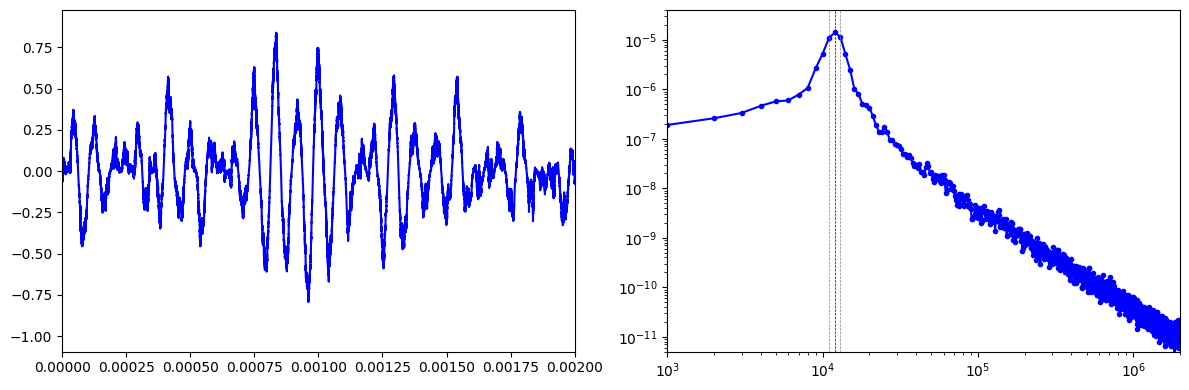

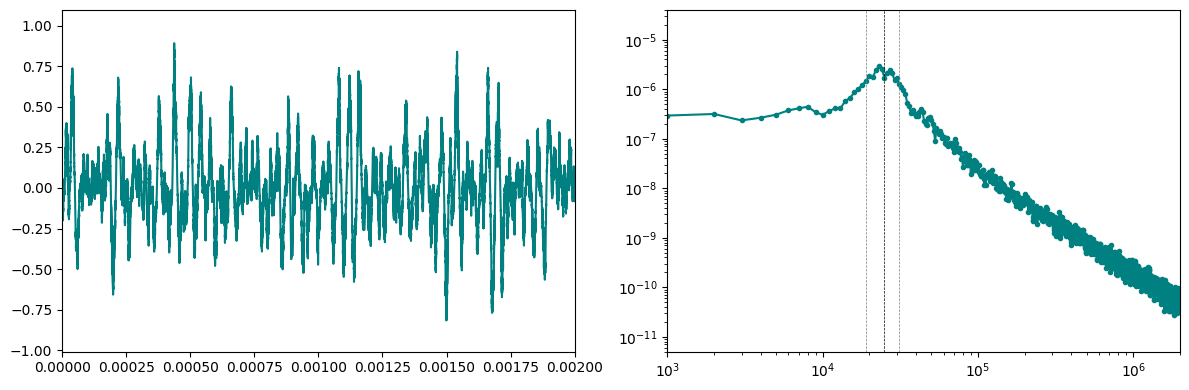

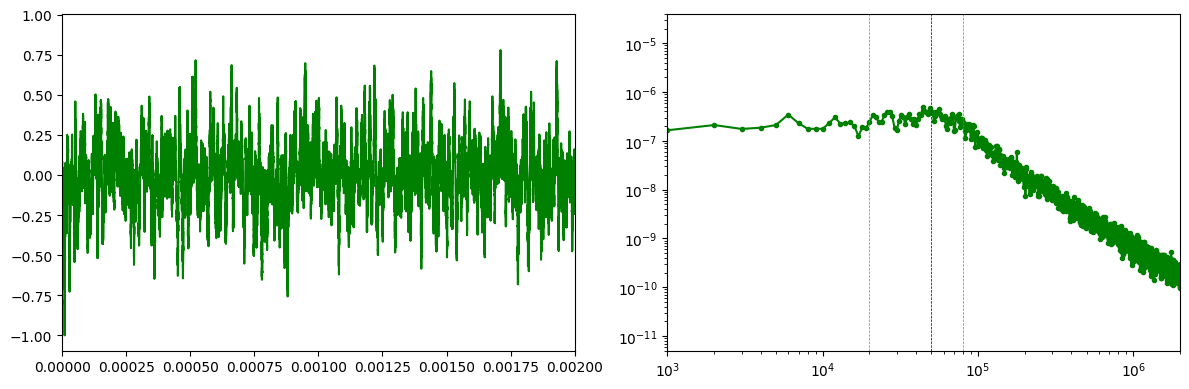

In [3]:
for _,(f0,Df,t,n,f,PSD,color) in enumerate(
    zip([f0_1, f0_2, f0_3], [Df_1, Df_2, Df_3],
        [t_vec_1,t_vec_2,t_vec_3], [n_vec_1,n_vec_2,n_vec_3],
        [f_vec_1,f_vec_2,f_vec_3], [PSD_vec_1,PSD_vec_2,PSD_vec_3],
        ['blue','teal','green'])):
    plot_noise_PSD(
        t,n,f,PSD,t_lims=t_lims,mag_lims=mag_lims,f0=f0,Df=Df,
        f_lims=f_lims,PSD_lims=PSD_lims,color=color,figsize=figsize,
        save_name=f'Noise_PSD_f{int(f0*1e-3)}kHz_Df{int(Df*1e-3)}kHz',save_format='svg'
        )